# Properties of transfer matrices induced by unitaries

Created 06/06/2024

Objectives:
* When acting with the transfer matrices derived from unitaries on these states, are there extra requirements?
    * Vector norm less than or equal to one?
    * Is there only a subspace of the entire space accessible?
    * Compare transfer matrices from unitaries with more general operators. What properties do transfer matrices from unitaries have?

# Package imports

In [207]:
from functools import reduce
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [18]:
from SPTOptimization.super_fibonacci import super_fibonacci

In [30]:
from SPTOptimization.utils import (
    get_transfer_matrix_from_unitary,
    get_transfer_matrices_from_unitary_list,
    multiply_transfer_matrices,
    to_npc_array
)

# Load data

In [8]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [9]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [10]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [11]:
psi_dict = dict()

In [12]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [13]:
list(psi_dict)

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0]

In [14]:
test_psi = psi_dict[0.5]

# Definitions

In [3]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [21]:
base_unitaries = np.array([np_I, 1j*np_X, 1j*np_Y, 1j*np_Z])

In [4]:
def get_symmetry_tm(psi, symmetry_operations):
    index = (psi.L - len(symmetry_operations))//2

    tms = get_transfer_matrices_from_unitary_list(
        psi,
        symmetry_operations,
        index
    )

    transfer_matrix = reduce(
        multiply_transfer_matrices,
        tms
    )

    np_transfer_matrix = (
        transfer_matrix
        .combine_legs([['vL', 'vL*'], ['vR', 'vR*']])
        .to_ndarray()
    )

    return np_transfer_matrix

In [54]:
def get_left_right_projected_states(symmetry_transfer_matrix):
    U, S, Vh = np.linalg.svd(symmetry_transfer_matrix)

    return (S[0], U[:, 0], Vh[0])

# Code
## Testing

In [20]:
symmetry_tms = [
    get_symmetry_tm(psi, [np_X, np_I]*40)
    for psi in psi_dict.values()
]

In [32]:
def get_base_transfer_matrices(psi, site_index):
    X = np.array([
        get_transfer_matrix_from_unitary(psi, u, site_index)
        .combine_legs([['vL', 'vL*'], ['vR', 'vR*']])
        .to_ndarray()
        for u in base_unitaries
    ])

    return X

In [36]:
def operator_norm(X):
    return np.linalg.SVD(X).S[0]

In [25]:
base_index = (test_psi.L + 80)//2

In [26]:
base_index

140

In [33]:
base_transfer_matrices = get_base_transfer_matrices(test_psi, base_index)

In [35]:
base_transfer_matrices.shape

(4, 64, 64)

In [45]:
sing_vals = np.round(np.linalg.svd(base_transfer_matrices).S, 3)

In [47]:
(
    Counter(sing_vals[0]),
    Counter(sing_vals[1]),
    Counter(sing_vals[2]),
    Counter(sing_vals[3])
)

(Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}))

In [133]:
s3_points = super_fibonacci(int(2e4))
s3_search_points = s3_points[s3_points[:, 0] >=  0]

In [134]:
s3_points.shape

(20000, 4)

In [52]:
test_symmetry_tm = symmetry_tms[5]

In [56]:
*_, test_right_projected_state = get_left_right_projected_states(test_symmetry_tm)

In [58]:
test_right_projected_state.shape

(64,)

In [59]:
np.linalg.norm(test_right_projected_state)

1.0

In [60]:
test_next_base_points = np.tensordot(
    test_right_projected_state,
    base_transfer_matrices,
    [[0,], [1,]]
)

In [90]:
np.linalg.norm(test_next_base_points, axis=1)

array([0.25989061, 1.        , 0.96532736, 0.02449415])

In [61]:
test_next_base_points.shape

(4, 64)

In [62]:
test_next_points = np.tensordot(
    s3_search_points,
    test_next_base_points,
    [[1,], [0,]]
)

In [63]:
test_next_points.shape

(10003, 64)

In [64]:
test_next_points_norm = np.linalg.norm(test_next_points, axis=1)

In [66]:
pd.Series(test_next_points_norm).describe()

count    10003.000000
mean         0.673947
std          0.213655
min          0.032207
25%          0.516259
50%          0.707193
75%          0.855978
max          0.999486
dtype: float64

In [67]:
next_base_transfer_matrices = get_base_transfer_matrices(test_psi, base_index+1)

In [69]:
next_sing_vals = np.round(np.linalg.svd(next_base_transfer_matrices).S, 3)

In [71]:
(
    Counter(next_sing_vals[0]),
    Counter(next_sing_vals[1]),
    Counter(next_sing_vals[2]),
    Counter(next_sing_vals[3])
)

(Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({1.39: 16, 0.259: 16, 0.033: 16, 0.006: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}),
 Counter({0.0: 32, 1.39: 16, 0.261: 16}))

In [72]:
test_2_base_points = np.tensordot(
    test_next_points,
    base_transfer_matrices,
    [[1,], [1,]]
)

In [74]:
test_2_base_points.shape

(10003, 4, 64)

In [187]:
test_2_points = np.tensordot(
    s3_search_points[3::5],
    test_2_base_points[2::5],
    [[1,], [1,]]
)

In [188]:
test_2_points.shape

(2000, 2001, 64)

In [189]:
test_2_norms = np.linalg.norm(test_2_points, axis=-1)

In [190]:
pd.Series(test_2_norms.flatten()).describe()

count    4.002000e+06
mean     4.517203e-01
std      2.093431e-01
min      1.173027e-02
25%      2.844637e-01
50%      4.380686e-01
75%      6.093696e-01
max      9.977682e-01
dtype: float64

In [191]:
max_2_norms = np.max(test_2_norms, axis=0)

In [192]:
max_2_norms.shape

(2001,)

In [193]:
norm_2_1_ratio = max_2_norms/test_next_points_norm[2::5]

In [194]:
norm_2_1_ratio.shape

(2001,)

In [195]:
pd.Series(norm_2_1_ratio).describe()

count    2001.000000
mean        0.998553
std         0.001990
min         0.997837
25%         0.998200
50%         0.998355
75%         0.998613
max         1.082165
dtype: float64

## Right side

In [212]:
s3_points = super_fibonacci(int(4e3))
s3_search_points = s3_points[s3_points[:, 0] >=  0]

In [213]:
s3_points.shape

(4000, 4)

In [100]:
def describe_1d_array(X):
    return pd.Series(X).describe()

In [251]:
def check_ratios_and_distances(psi, right_projected_state):
    base_transfer_matrices_1 = get_base_transfer_matrices(psi, base_index)
    base_transfer_matrices_2 = get_base_transfer_matrices(psi, base_index+1)

    base_sing_vals_1 = np.round(np.linalg.svd(base_transfer_matrices_1).S, 3)
    base_sing_vals_2 = np.round(np.linalg.svd(base_transfer_matrices_2).S, 3)

    base_points_1 = np.tensordot(
        right_projected_state,
        base_transfer_matrices_1,
        [[0,], [1,]]
    )
    
    virtual_points_1 = np.tensordot(
        s3_search_points,
        base_points_1,
        [[1,], [0,]]
    )

    norm_virtual_points_1 = np.linalg.norm(virtual_points_1, axis=-1)
    norms_1_stats = describe_1d_array(norm_virtual_points_1)

    base_points_2 = np.tensordot(
        virtual_points_1,
        base_transfer_matrices_2,
        [[1,], [1,]]
    )

    stride_length = 10

    norms_2 = np.zeros((len(s3_search_points), len(virtual_points_1)))
    ratios = np.zeros((len(virtual_points_1,)))

    steps = len(virtual_points_1)//stride_length

    for i in range(steps):
        virtual_2_points = np.tensordot(
            s3_search_points,
            base_points_2[stride_length*i:stride_length*(i+1)],
            [[1,], [1,]]
        )

        norms = np.linalg.norm(virtual_2_points, axis=2)
        norms_2[:, stride_length*i:stride_length*(i+1)] = norms
        
        max_virtual_2_norms = np.max(norms, axis=0)
        norms_ratio = max_virtual_2_norms/norm_virtual_points_1[stride_length*i:stride_length*(i+1)]

        ratios[stride_length*i:stride_length*(i+1)] = norms_ratio

    ratios_desc = describe_1d_array(ratios)
    norms_2_stats = describe_1d_array(norms_2.flatten())

    return {
        "base_sing_vals_1": base_sing_vals_1,
        "base_sing_vals_2": base_sing_vals_2,
        "norms_1": norm_virtual_points_1,
        "norm_virtual_points_1_stats": norms_1_stats,
        "max_norms_2": np.max(norms_2, axis=0),
        "norm_virtual_points_2_stats": norms_2_stats,
        "2_to_1_ratios_stats": ratios_desc
    }

In [252]:
d = check_ratios_and_distances(test_psi, test_right_projected_state)

In [253]:
d['2_to_1_ratios_stats']

count    2003.000000
mean        0.898034
std         0.087201
min         0.000000
25%         0.836557
50%         0.915754
75%         0.971668
max         0.998964
dtype: float64

In [254]:
d['norm_virtual_points_2_stats']

count    4.012009e+06
mean     4.659138e-01
std      1.793613e-01
min      0.000000e+00
25%      3.289461e-01
50%      4.671123e-01
75%      6.009240e-01
max      9.971007e-01
dtype: float64

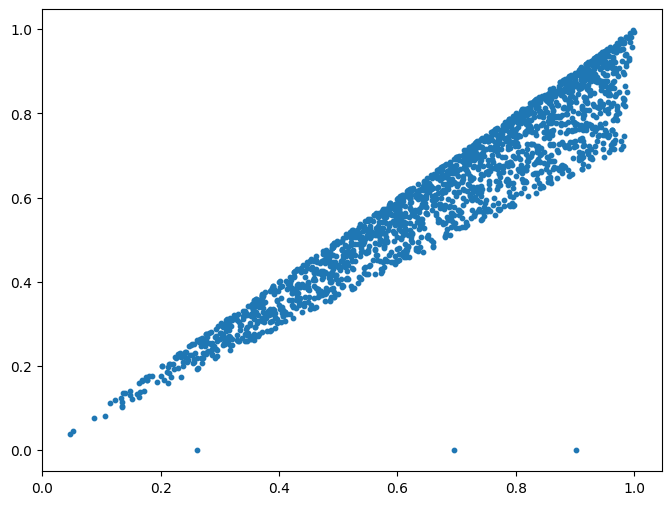

In [255]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

In [276]:
left_projected_states = list()
right_projected_states = list()

for tm in symmetry_tms:
    _, left_projected_state, right_projected_state = (
        get_left_right_projected_states(tm)
    )

    left_projected_states.append(left_projected_state)
    right_projected_states.append(right_projected_state)

In [257]:
right_ratios_and_norms = [
    check_ratios_and_distances(psi, right_projected_state)
    for psi, right_projected_state in zip(psi_dict.values(), right_projected_states)
]

### Singular values 1

In [258]:
right_ratios_and_norms[0]["base_sing_vals_1"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [259]:
right_ratios_and_norms[1]["base_sing_vals_1"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [228]:
right_ratios_and_norms[5]["base_sing_vals_1"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [229]:
right_ratios_and_norms[9]["base_sing_vals_1"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [230]:
right_ratios_and_norms[11]["base_sing_vals_1"]

array([[1.392e+00, 1.388e+00, 1.388e+00, 1.385e+00, 1.368e+00, 1.368e+00,
        1.364e+00, 1.364e+00, 1.346e+00, 1.014e+00, 1.014e+00, 1.013e+00,
        1.013e+00, 1.004e+00, 1.003e+00, 1.003e+00, 1.003e+00, 1.002e+00,
        1.002e+00, 1.000e+00, 9.900e-01, 9.820e-01, 9.750e-01, 9.400e-01,
        9.400e-01, 2.910e-01, 2.870e-01, 2.870e-01, 2.820e-01, 2.720e-01,
        2.720e-01, 2.650e-01, 2.650e-01, 2.460e-01, 1.830e-01, 1.770e-01,
        1.710e-01, 1.680e-01, 1.680e-01, 1.680e-01, 1.680e-01, 1.680e-01,
        1.450e-01, 1.450e-01, 1.440e-01, 1.440e-01, 6.400e-02, 6.200e-02,
        6.200e-02, 6.000e-02, 5.700e-02, 5.700e-02, 5.400e-02, 5.400e-02,
        5.100e-02, 1.300e-02, 1.300e-02, 1.300e-02, 1.300e-02, 1.100e-02,
        1.100e-02, 1.100e-02, 1.100e-02, 9.000e-03],
       [1.392e+00, 1.388e+00, 1.388e+00, 1.385e+00, 1.368e+00, 1.368e+00,
        1.364e+00, 1.364e+00, 1.346e+00, 1.014e+00, 1.014e+00, 1.013e+00,
        1.013e+00, 1.004e+00, 1.003e+00, 1.003e+00, 1.003e+

In [231]:
right_ratios_and_norms[15]["base_sing_vals_1"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [232]:
right_ratios_and_norms[20]["base_sing_vals_1"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

Conclusions:
* The 4 groups of 16 fold degenerate singular values seems peculiar to the non trivial phase, and so is likely a result of entanglement spectrum degeneracy.
* Regardless of B, the transfer matrices seem to have a similar maximum singular value (operator norm) of about 1.4

### Singular values 2

In [233]:
right_ratios_and_norms[0]["base_sing_vals_2"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [234]:
right_ratios_and_norms[1]["base_sing_vals_2"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [235]:
right_ratios_and_norms[5]["base_sing_vals_2"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [237]:
right_ratios_and_norms[9]["base_sing_vals_2"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [240]:
right_ratios_and_norms[11]["base_sing_vals_2"]

array([[1.354, 1.305, 1.305, 1.269, 1.204, 1.204, 1.187, 1.186, 1.136,
        1.002, 1.002, 1.002, 1.001, 1.001, 0.999, 0.997, 0.996, 0.996,
        0.993, 0.969, 0.969, 0.964, 0.963, 0.963, 0.962, 0.823, 0.753,
        0.748, 0.666, 0.666, 0.644, 0.644, 0.642, 0.642, 0.609, 0.464,
        0.464, 0.422, 0.399, 0.399, 0.396, 0.396, 0.305, 0.267, 0.255,
        0.21 , 0.168, 0.163, 0.162, 0.136, 0.135, 0.134, 0.133, 0.092,
        0.092, 0.079, 0.064, 0.064, 0.053, 0.053, 0.041, 0.023, 0.023,
        0.007],
       [1.354, 1.305, 1.305, 1.269, 1.204, 1.204, 1.187, 1.186, 1.136,
        1.002, 1.002, 1.002, 1.001, 1.001, 0.999, 0.997, 0.996, 0.996,
        0.993, 0.969, 0.969, 0.964, 0.963, 0.963, 0.962, 0.823, 0.753,
        0.748, 0.666, 0.666, 0.644, 0.644, 0.642, 0.642, 0.609, 0.464,
        0.464, 0.422, 0.399, 0.399, 0.396, 0.396, 0.305, 0.267, 0.255,
        0.21 , 0.168, 0.163, 0.162, 0.136, 0.135, 0.134, 0.133, 0.092,
        0.092, 0.079, 0.064, 0.064, 0.053, 0.053, 0.041, 0.02

In [239]:
right_ratios_and_norms[15]["base_sing_vals_2"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [238]:
right_ratios_and_norms[20]["base_sing_vals_2"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

Conclusions:
* No change from previous case 

### Norms of first virtual points

In [260]:
for i, d in enumerate(right_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["norm_virtual_points_1_stats"])


 i=0
count    2003.000000
mean        0.694087
std         0.133068
min         0.431455
25%         0.583073
50%         0.709092
75%         0.808818
max         0.901961
dtype: float64

 i=1
count    2003.000000
mean        0.672530
std         0.216575
min         0.159915
25%         0.508422
50%         0.710039
75%         0.856041
max         0.986915
dtype: float64

 i=2
count    2003.000000
mean        0.686988
std         0.165510
min         0.337296
25%         0.552993
50%         0.709813
75%         0.829838
max         0.941296
dtype: float64

 i=3
count    2003.000000
mean        0.700700
std         0.097036
min         0.506912
25%         0.620128
50%         0.706849
75%         0.785933
max         0.862561
dtype: float64

 i=4
count    2003.000000
mean        0.673490
std         0.213545
min         0.114406
25%         0.511893
50%         0.709253
75%         0.855765
max         0.993578
dtype: float64

 i=5
count    2003.000000
mean        0.673367
std    

Concluisons:
Wide spread in values across the board.

### Max of norm of second virtual points against norm of first virtual point

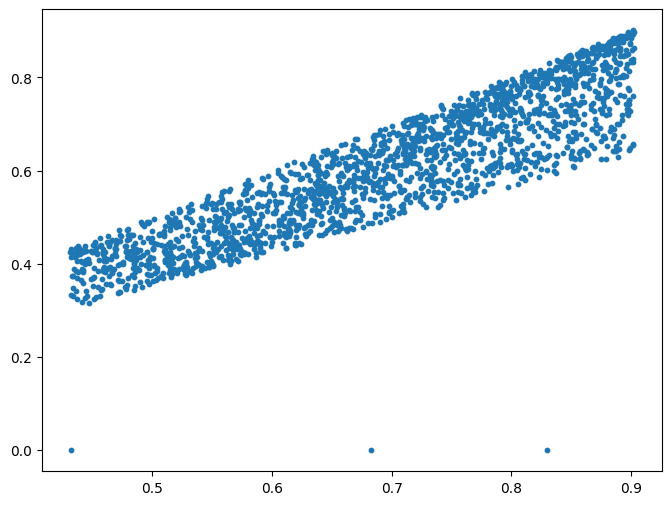

In [261]:
i = 0
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

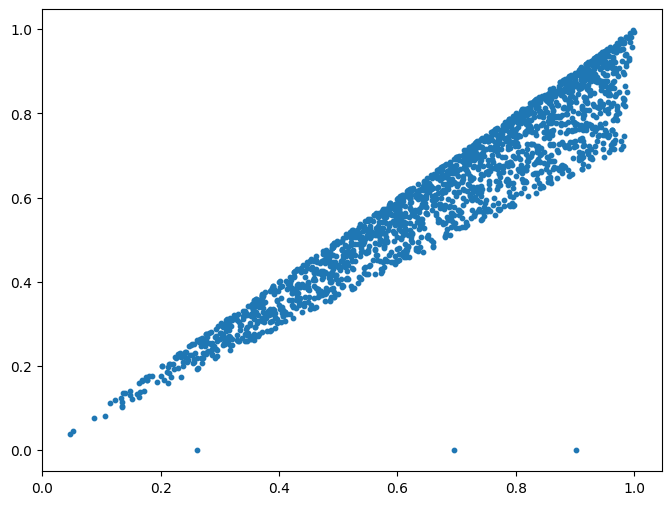

In [262]:
i = 5
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

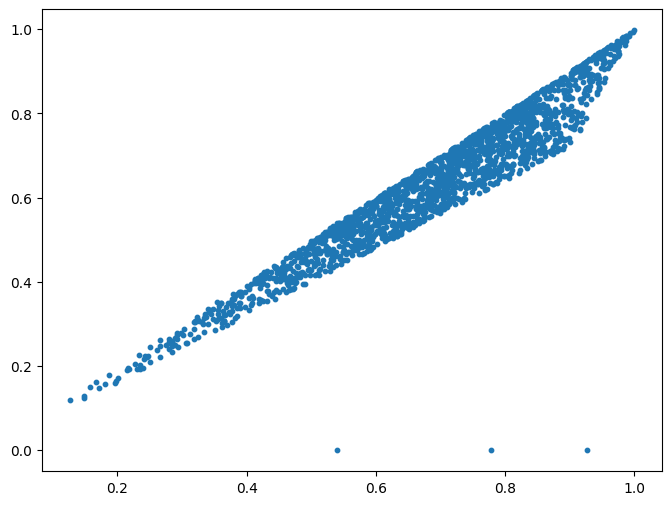

In [263]:
i = 9
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

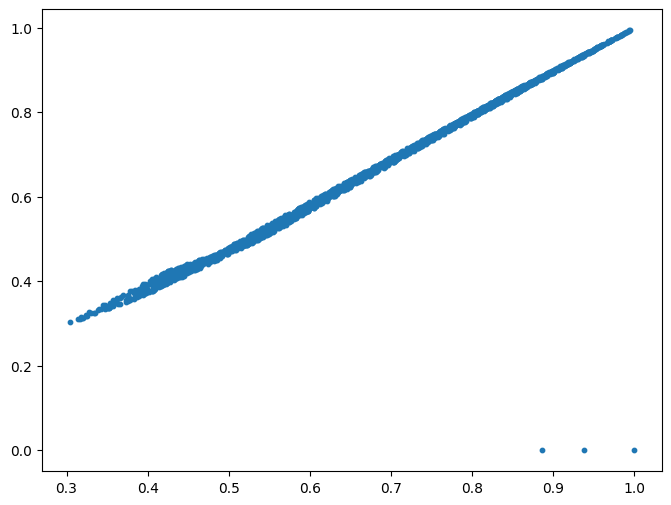

In [264]:
i = 11
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

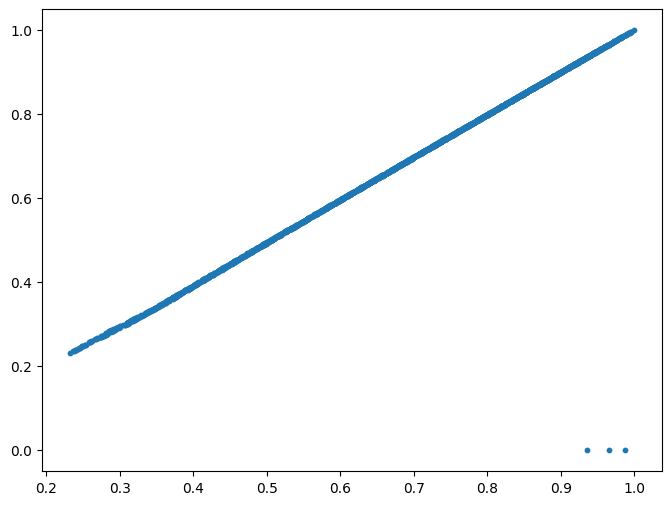

In [265]:
i = 15
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

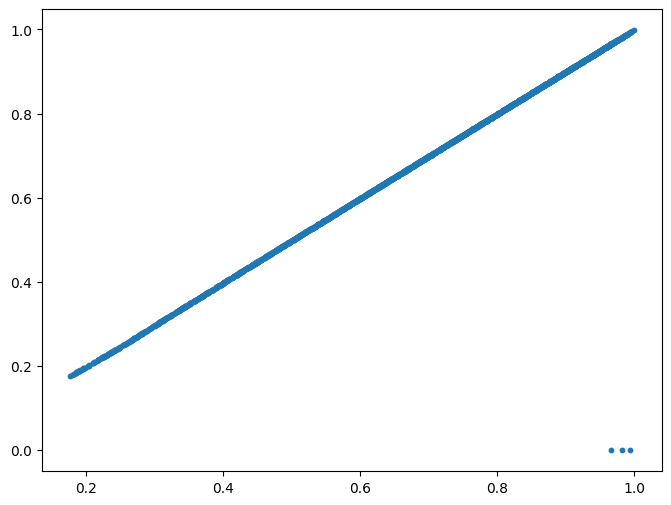

In [266]:
i = 20
d = right_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

Conclusions:
* Interesting "tightening" of the spread depending on B.
* In general, a lower prior norm implies a lower future norm. This is surprising, considering the operator norms of the transfer matrices are about 1.4.

### Ratio of norms

In [267]:
for i, d in enumerate(right_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["2_to_1_ratios_stats"])


 i=0
count    2003.000000
mean        0.868605
std         0.091068
min         0.000000
25%         0.797645
50%         0.876086
75%         0.944505
max         0.999882
dtype: float64

 i=1
count    2003.000000
mean        0.888276
std         0.091702
min         0.000000
25%         0.819301
50%         0.907459
75%         0.967082
max         0.999478
dtype: float64

 i=2
count    2003.000000
mean        0.875296
std         0.087931
min         0.000000
25%         0.805108
50%         0.885132
75%         0.947655
max         0.998885
dtype: float64

 i=3
count    2003.000000
mean        0.868367
std         0.083033
min         0.000000
25%         0.802238
50%         0.872854
75%         0.936286
max         0.998578
dtype: float64

 i=4
count    2003.000000
mean        0.892784
std         0.086844
min         0.000000
25%         0.829216
50%         0.909665
75%         0.966391
max         0.999071
dtype: float64

 i=5
count    2003.000000
mean        0.898034
std    

Conclusions:
* All pretty much bounded with max 1, how weird.

## Left side

In [250]:
base_index = (test_psi.L - 80)//2 -1

In [279]:
def left_check_ratios_and_distances(psi, left_projected_state):
    base_transfer_matrices_1 = get_base_transfer_matrices(psi, base_index)
    base_transfer_matrices_2 = get_base_transfer_matrices(psi, base_index-1)

    base_sing_vals_1 = np.round(np.linalg.svd(base_transfer_matrices_1).S, 3)
    base_sing_vals_2 = np.round(np.linalg.svd(base_transfer_matrices_2).S, 3)

    base_points_1 = np.tensordot(
        left_projected_state,
        base_transfer_matrices_1,
        [[0,], [2,]]
    )
    
    virtual_points_1 = np.tensordot(
        s3_search_points,
        base_points_1,
        [[1,], [0,]]
    )

    norm_virtual_points_1 = np.linalg.norm(virtual_points_1, axis=-1)
    norms_1_stats = describe_1d_array(norm_virtual_points_1)

    base_points_2 = np.tensordot(
        virtual_points_1,
        base_transfer_matrices_2,
        [[1,], [2,]]
    )

    stride_length = 10

    norms_2 = np.zeros((len(s3_search_points), len(virtual_points_1)))
    ratios = np.zeros((len(virtual_points_1,)))

    steps = len(virtual_points_1)//stride_length

    for i in range(steps):
        virtual_2_points = np.tensordot(
            s3_search_points,
            base_points_2[stride_length*i:stride_length*(i+1)],
            [[1,], [1,]]
        )

        norms = np.linalg.norm(virtual_2_points, axis=2)
        norms_2[:, stride_length*i:stride_length*(i+1)] = norms
        
        max_virtual_2_norms = np.max(norms, axis=0)
        norms_ratio = max_virtual_2_norms/norm_virtual_points_1[stride_length*i:stride_length*(i+1)]

        ratios[stride_length*i:stride_length*(i+1)] = norms_ratio

    ratios_desc = describe_1d_array(ratios)
    norms_2_stats = describe_1d_array(norms_2.flatten())

    return {
        "base_sing_vals_1": base_sing_vals_1,
        "base_sing_vals_2": base_sing_vals_2,
        "norms_1": norm_virtual_points_1,
        "norm_virtual_points_1_stats": norms_1_stats,
        "max_norms_2": np.max(norms_2, axis=0),
        "norm_virtual_points_2_stats": norms_2_stats,
        "2_to_1_ratios_stats": ratios_desc
    }

In [278]:
left_ratios_and_norms = [
    left_check_ratios_and_distances(psi, left_projected_state)
    for psi, left_projected_state in zip(psi_dict.values(), left_projected_states)
]

(4,)
(4, 4, 4)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)
(64,)
(4, 64, 64)


### Singular values 1

In [283]:
left_ratios_and_norms[0]["base_sing_vals_1"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [284]:
left_ratios_and_norms[1]["base_sing_vals_1"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [285]:
left_ratios_and_norms[5]["base_sing_vals_1"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [286]:
left_ratios_and_norms[9]["base_sing_vals_1"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.52 ,
        0.52 , 0.52 , 0.52 , 0.52 , 0.52 , 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [287]:
left_ratios_and_norms[11]["base_sing_vals_1"]

array([[1.358, 1.357, 1.357, 1.355, 1.27 , 1.27 , 1.269, 1.269, 1.215,
        1.001, 1.001, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.998,
        0.998, 0.998, 0.997, 0.997, 0.996, 0.996, 0.996, 0.706, 0.546,
        0.546, 0.542, 0.542, 0.505, 0.505, 0.505, 0.505, 0.269, 0.201,
        0.188, 0.188, 0.173, 0.156, 0.132, 0.131, 0.131, 0.13 , 0.112,
        0.111, 0.111, 0.111, 0.077, 0.077, 0.067, 0.064, 0.041, 0.036,
        0.036, 0.034, 0.034, 0.033, 0.028, 0.028, 0.006, 0.005, 0.005,
        0.004],
       [1.358, 1.357, 1.357, 1.355, 1.27 , 1.27 , 1.269, 1.269, 1.215,
        1.001, 1.001, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.998,
        0.998, 0.998, 0.997, 0.997, 0.996, 0.996, 0.996, 0.706, 0.546,
        0.546, 0.542, 0.542, 0.505, 0.505, 0.505, 0.505, 0.269, 0.201,
        0.188, 0.188, 0.173, 0.156, 0.132, 0.131, 0.131, 0.13 , 0.112,
        0.111, 0.111, 0.111, 0.077, 0.077, 0.067, 0.064, 0.041, 0.036,
        0.036, 0.034, 0.034, 0.033, 0.028, 0.028, 0.006, 0.00

In [288]:
left_ratios_and_norms[15]["base_sing_vals_1"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [289]:
left_ratios_and_norms[20]["base_sing_vals_1"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

### Singular values 2

In [290]:
left_ratios_and_norms[0]["base_sing_vals_2"]

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [291]:
left_ratios_and_norms[1]["base_sing_vals_2"]

array([[1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
        5.000e-02, 5.000e-02, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00,
        1.413e+00, 1.413e+00, 1.413e+00, 1.413e+00, 5.000e-

In [292]:
left_ratios_and_norms[5]["base_sing_vals_2"]

array([[1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006],
       [1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 ,
        1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 1.39 , 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259, 0.259,
        0.259, 0.259, 0.259, 0.259, 0.259, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033, 0.033,
        0.033, 0.033, 0.033, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
        0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.00

In [293]:
left_ratios_and_norms[9]["base_sing_vals_2"]

array([[1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054],
       [1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311,
        1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 1.311, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521, 0.521,
        0.521, 0.521, 0.521, 0.521, 0.521, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135, 0.135,
        0.135, 0.135, 0.135, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
        0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.05

In [294]:
left_ratios_and_norms[11]["base_sing_vals_2"]

array([[1.349, 1.348, 1.348, 1.348, 1.261, 1.261, 1.261, 1.261, 1.207,
        1.   , 1.   , 1.   , 1.   , 0.998, 0.998, 0.998, 0.998, 0.996,
        0.996, 0.996, 0.996, 0.994, 0.994, 0.994, 0.994, 0.72 , 0.565,
        0.565, 0.564, 0.564, 0.518, 0.518, 0.518, 0.518, 0.278, 0.248,
        0.246, 0.246, 0.243, 0.166, 0.163, 0.162, 0.162, 0.161, 0.16 ,
        0.159, 0.159, 0.158, 0.095, 0.095, 0.093, 0.093, 0.053, 0.052,
        0.052, 0.052, 0.044, 0.044, 0.043, 0.043, 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [1.349, 1.348, 1.348, 1.348, 1.261, 1.261, 1.261, 1.261, 1.207,
        1.   , 1.   , 1.   , 1.   , 0.998, 0.998, 0.998, 0.998, 0.996,
        0.996, 0.996, 0.996, 0.994, 0.994, 0.994, 0.994, 0.72 , 0.565,
        0.565, 0.564, 0.564, 0.518, 0.518, 0.518, 0.518, 0.278, 0.248,
        0.246, 0.246, 0.243, 0.166, 0.163, 0.162, 0.162, 0.161, 0.16 ,
        0.159, 0.159, 0.158, 0.095, 0.095, 0.093, 0.093, 0.053, 0.052,
        0.052, 0.052, 0.044, 0.044, 0.043, 0.043, 0.01 , 0.01

In [295]:
left_ratios_and_norms[15]["base_sing_vals_2"]

array([[1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.003, 0.003,
        0.003],
       [1.387, 1.387, 1.387, 1.387, 1.343, 1.343, 1.343, 1.343, 1.307,
        1.   , 1.   , 1.   , 1.   , 0.999, 0.999, 0.999, 0.999, 0.999,
        0.999, 0.999, 0.999, 0.998, 0.998, 0.998, 0.998, 0.52 , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.359, 0.359, 0.359, 0.359, 0.187, 0.137,
        0.137, 0.137, 0.137, 0.086, 0.086, 0.086, 0.086, 0.085, 0.085,
        0.085, 0.085, 0.074, 0.051, 0.051, 0.05 , 0.05 , 0.029, 0.028,
        0.028, 0.028, 0.015, 0.015, 0.015, 0.015, 0.003, 0.00

In [296]:
left_ratios_and_norms[20]["base_sing_vals_2"]

array([[1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 9.990e-01, 9.990e-01, 9.990e-01,
        9.990e-01, 3.830e-01, 2.900e-01, 2.900e-01, 2.900e-01, 2.900e-01,
        2.600e-01, 2.600e-01, 2.600e-01, 2.600e-01, 1.330e-01, 7.800e-02,
        7.800e-02, 7.800e-02, 7.800e-02, 4.800e-02, 4.800e-02, 4.800e-02,
        4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 4.800e-02, 3.700e-02,
        2.800e-02, 2.800e-02, 2.800e-02, 2.800e-02, 1.600e-02, 1.600e-02,
        1.600e-02, 1.600e-02, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 1.000e-03, 1.000e-03, 1.000e-03],
       [1.401e+00, 1.401e+00, 1.401e+00, 1.401e+00, 1.377e+00, 1.377e+00,
        1.377e+00, 1.377e+00, 1.356e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+

Conclusions:
* No change from previous case 

### Norms of first virtual points

In [297]:
for i, d in enumerate(left_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["norm_virtual_points_1_stats"])


 i=0
count    2003.000000
mean        0.667453
std         0.235374
min         0.025355
25%         0.504411
50%         0.703933
75%         0.868833
max         0.999928
dtype: float64

 i=1
count    2003.000000
mean        0.999374
std         0.000362
min         0.998746
25%         0.999065
50%         0.999367
75%         0.999692
max         0.999999
dtype: float64

 i=2
count    2003.000000
mean        0.997468
std         0.001461
min         0.994927
25%         0.996218
50%         0.997441
75%         0.998752
max         0.999995
dtype: float64

 i=3
count    2003.000000
mean        0.994198
std         0.003341
min         0.988364
25%         0.991334
50%         0.994149
75%         0.997130
max         0.999988
dtype: float64

 i=4
count    2003.000000
mean        0.989408
std         0.006082
min         0.978728
25%         0.984187
50%         0.989328
75%         0.994750
max         0.999978
dtype: float64

 i=5
count    2003.000000
mean        0.982847
std    

Concluisons:
Wide spread in values across the board.

### Max of norm of second virtual points against norm of first virtual point

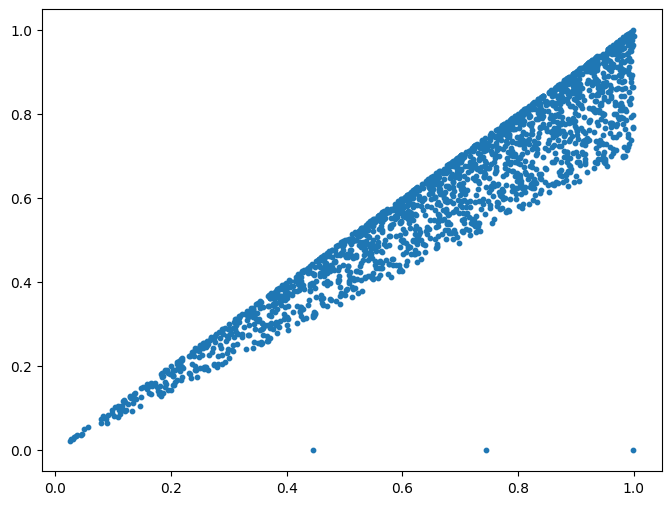

In [298]:
i = 0
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

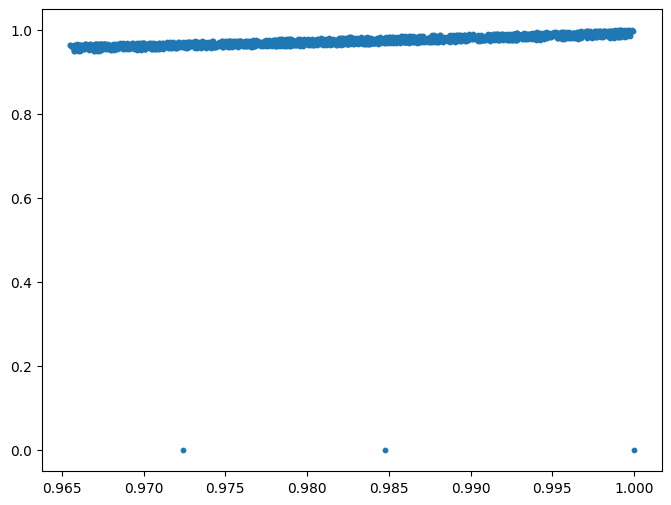

In [299]:
i = 5
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

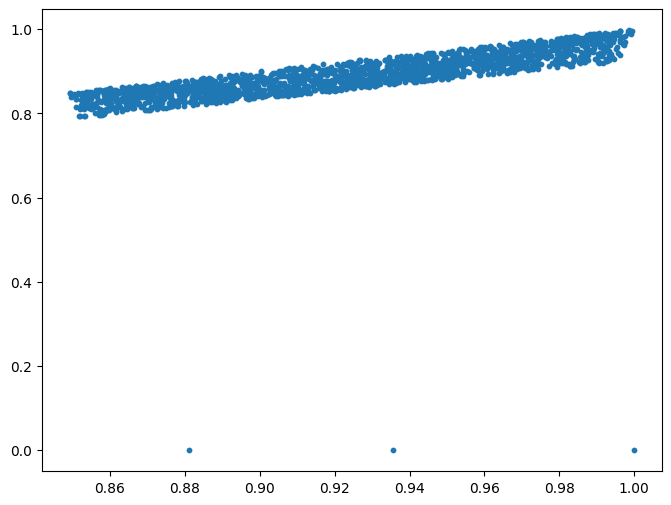

In [300]:
i = 9
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

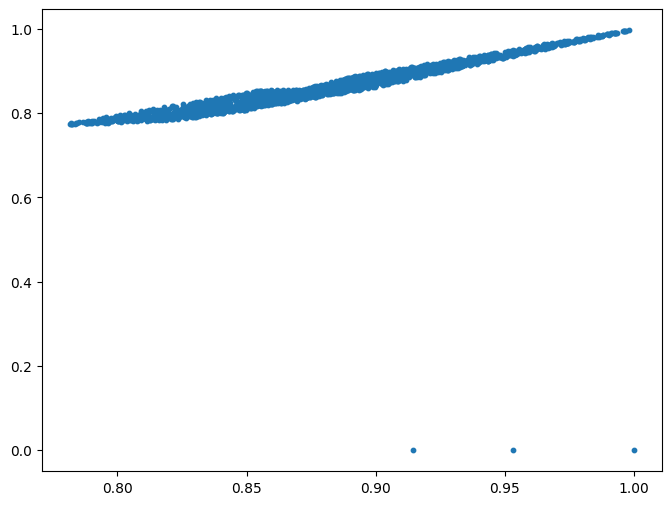

In [301]:
i = 11
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

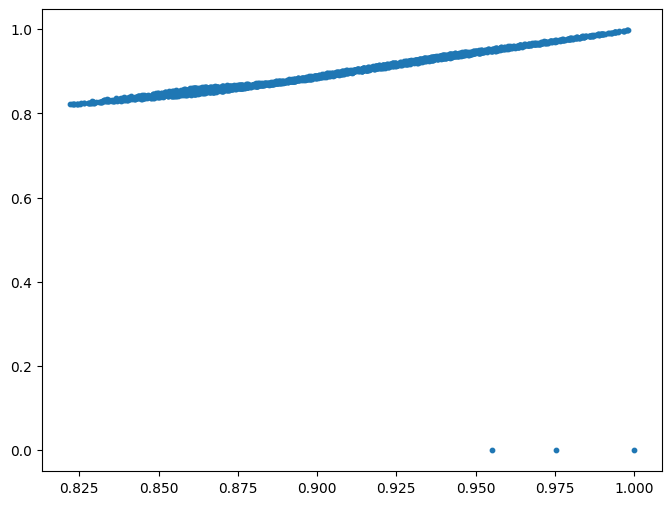

In [302]:
i = 15
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

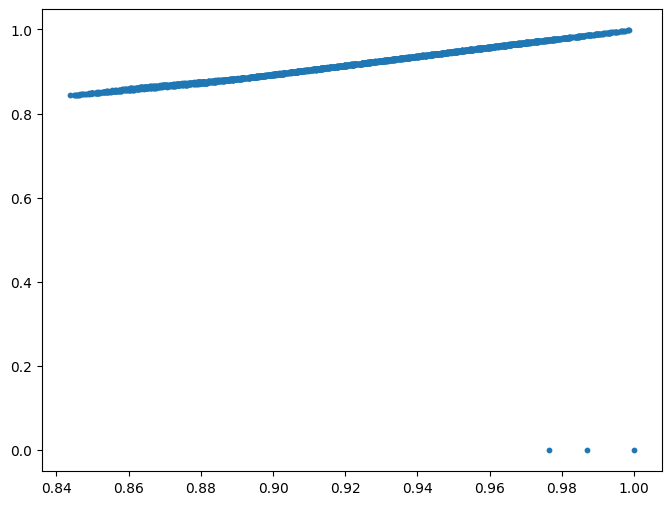

In [303]:
i = 20
d = left_ratios_and_norms[i]

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(d['norms_1'], d['max_norms_2'] ,s=10)

Conclusions:
* Quite different behaviour to right side. Makes sense considering the assymmetry of the symmetry operation.

### Ratio of norms

In [304]:
for i, d in enumerate(left_ratios_and_norms):
    print("\n i={}".format(i))
    print(d["2_to_1_ratios_stats"])


 i=0
count    2003.000000
mean        0.898307
std         0.095170
min         0.000000
25%         0.826933
50%         0.924269
75%         0.981067
max         0.999928
dtype: float64

 i=1
count    2003.000000
mean        0.998189
std         0.038670
min         0.000000
25%         0.999529
50%         0.999686
75%         0.999842
max         0.999999
dtype: float64

 i=2
count    2003.000000
mean        0.997235
std         0.038639
min         0.000000
25%         0.998096
50%         0.998730
75%         0.999362
max         0.999994
dtype: float64

 i=3
count    2003.000000
mean        0.995601
std         0.038605
min         0.000000
25%         0.995637
50%         0.997089
75%         0.998544
max         0.999986
dtype: float64

 i=4
count    2003.000000
mean        0.993215
std         0.038597
min         0.000000
25%         0.992062
50%         0.994697
75%         0.997352
max         0.999975
dtype: float64

 i=5
count    2003.000000
mean        0.989965
std    

Conclusions:
* Again, all bounded.

## Conclusions
Despite the operator norms being greater than one, it does indeed appear that the virtual vectors are bounded by unit length 1. A proof of this would be nice. This suggests looking for all admissable virtual vectors.
The bound on one virtual vector to the next should help a lot when it comes to searching for optimal solutions. Again, proof would be nice to justify this though. (Does this follow from the FCS theory?)
Could look into the particular vectors in question. What are the singular vectors corresponding to those singular values greater than one? Anything special about those vectors?
As nothing is proven, should really implement checks in solution methods going forward.